In [9]:
%matplotlib inline
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from preprocessing import read_data, articles_from_csv_reader, dummy_str_reader, get_word_embeddings, subgraph, \
    graph_candidates
from visualize import visualize, unfold_and_plot
import numpy as np
import spacy
import constants
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from IPython.display import Image
from IPython.display import display
from net import Net
from os.path import isdir

In [2]:
data_dir = '/home/arne/devel/ML/data/'
assert isdir(data_dir), 'data_dir='+data_dir+' is no directory'

dim = 300
edge_count = 60
seq_length = 10

slice_size = 30
max_forest_count = 5

nlp = spacy.load('en')
nlp.pipeline = [nlp.tagger, nlp.parser]

In [3]:
vecs, mapping, human_mapping = get_word_embeddings(nlp.vocab)
data_embedding_maps = {constants.WORD_EMBEDDING: mapping}
data_embedding_maps_human = {constants.WORD_EMBEDDING: human_mapping}
data_vecs = {constants.WORD_EMBEDDING: vecs}

Total time running get_word_embeddings: 7.96870994568 seconds


In [4]:
# create data arrays
(seq_data, seq_types, seq_parents, seq_edges), edge_map_human = \
    read_data(articles_from_csv_reader, nlp, data_embedding_maps, max_forest_count=max_forest_count, max_sen_length=slice_size,
              args={'max_articles': 1, 'filename': data_dir + 'corpora/documents_utf8_filtered_20pageviews.csv'})

parse 1 articles
read article: wikipedia-23885690 ...  0 %
Total time running read_data: 0.0941681861877 seconds


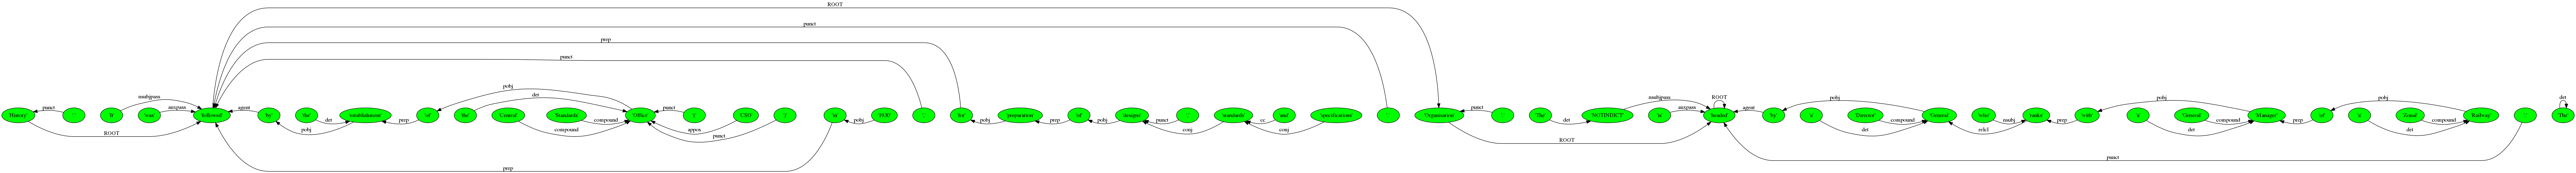

In [5]:
# take first 50 token and visualize the dependency graph
start = 0
end = 50
sliced_parents = subgraph(seq_parents, start, end)
sliced_data = seq_data[start:end]
sliced_types = seq_types[start:end]
sliced_edges = seq_edges[start:end]
visualize('forest.png', (sliced_data, sliced_types, sliced_parents, sliced_edges), data_embedding_maps_human, edge_map_human)
Image('forest.png')

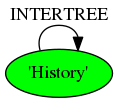

In [6]:
# create possible graphs (forests) for "new" data point with index = 9 (token: 'between')
ind = 0
graphs = graph_candidates(sliced_parents, ind)
for i, g in enumerate(graphs):
    fn = 'forest_'+str(i)+'.png'
    visualize(fn, (sliced_data[:(ind + 1)], sliced_types[:(ind + 1)], g, sliced_edges[:ind]+[0]),
              data_embedding_maps_human, edge_map_human)
    img = Image(fn)
    display(img)

In [7]:
net = Net(data_vecs, len(edge_map_human), dim, slice_size, max_forest_count)
print('output size:', net.max_graph_count * net.edge_count)

ind = 1

data = np.array(seq_data[0:(ind + 1)])
types = np.array(seq_types[0:(ind + 1)])
parents = subgraph(seq_parents, 0, (ind + 1))
edges = np.array(seq_edges[0:(ind + 1)])

graphs = np.array(graph_candidates(parents, ind))

outputs = net(data, types, np.array(parents), graphs)
outputs = outputs.unsqueeze(0)
print('outputs:\t', outputs)
outputs_soft = F.softmax(outputs)
print('softmax:\t', outputs_soft)
print('sum:\t', torch.sum(outputs))
print('sum_soft:\t', torch.sum(outputs_soft))

output size: 12400
outputs:	 Variable containing:
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x12400]

softmax:	 Variable containing:
1.00000e-05 *
 8.0645  8.0645  8.0645  ...   8.0645  8.0645  8.0645
[torch.FloatTensor of size 1x12400]

sum:	 Variable containing:
 0
[torch.FloatTensor of size 1]

sum_soft:	 Variable containing:
 1
[torch.FloatTensor of size 1]



12400
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


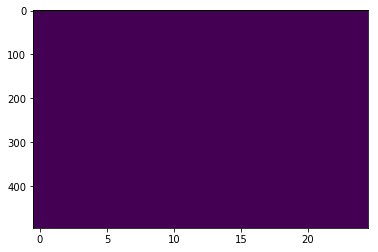

In [10]:
unfold_and_plot(outputs, net.edge_count)

12400
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


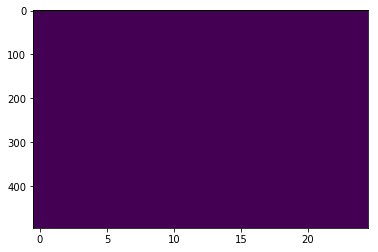

In [21]:
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
#optimizer = optim.Adagrad(net.get_parameters(), lr=0.01, lr_decay=0, weight_decay=0)    # default meta parameters

expected = Variable(torch.zeros(net.max_graph_count * net.edge_count).type(torch.FloatTensor))#, requires_grad=False)
expected[0] = 1

unfold_and_plot(expected, net.edge_count)

In [22]:
loss = F.cross_entropy(outputs_soft, expected)

TypeError: FloatClassNLLCriterion_updateOutput received an invalid combination of arguments - got (int, torch.FloatTensor, torch.FloatTensor, torch.FloatTensor, bool, NoneType, torch.FloatTensor), but expected (int state, torch.FloatTensor input, torch.LongTensor target, torch.FloatTensor output, bool sizeAverage, [torch.FloatTensor weights or None], torch.FloatTensor total_weight)

In [ ]:
def calc_embedding(data, types, parents, edges):
    # connect roots
    roots = [i for i, parent in enumerate(parents) if parent == 0]
    for i in range(len(roots) - 1):
        parents[roots[i]] = roots[i + 1]

    root = roots[-1]

    # calc child pointer
    children = {}
    for i, parent in enumerate(parents):
        parent_pos = i + parent
        # skip circle at root pos
        if parent_pos == i:
            continue
        if parent_pos not in children:
            children[parent_pos] = [i]
        else:
            children[parent_pos] += [i]

    return calc_embedding_rec(data, types, children, edges, root)


def calc_embedding_rec(data, types, children, edges, idx):
    # embedding = data_vecs[types[idx]][data[idx]] * data_weights[types[idx]] + data_biases[types[idx]]
    embedding = data_embedding_maps_human[types[idx]][data[idx]]

    # leaf
    if idx not in children:
        return embedding

    embedding += '['

    for child in children[idx]:
        # embedding += calc_embedding_rec(data, types, children, edges, child) * edge_weights[edges[child]] + edge_biases[edges[child]]
        embedding += ' ' + edge_map_human[edges[child]] + '(' + calc_embedding_rec(data, types, children, edges, child) + ')'

    embedding += ']'

    return embedding

print(calc_embedding(sliced_data, sliced_types, sliced_parents, sliced_edges))